# Accelerated Primal Dual to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Primal Dual framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, maximum, minimum
from numpy import asarray, add, subtract, multiply, tile
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from numpy.polynomial.chebyshev import chebpts1

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
#folder = 'Scalings'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
##New Data
#files = [f[:-6] for f in os.listdir(path) if f.endswith('.npy')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data16_1002-data16_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[0]
full_path = path + instance

Load data:

In [5]:
from scipy.sparse import load_npz

In [6]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

## New data
#m = np.load(full_path + '_m.npy');    M = m.size
# n = np.load(full_path + '_n.npy');    N = n.size
# c = np.load(full_path + '_Cost.npz')['c']
# sol = load_npz(full_path + '_Sol.npz').A

In [7]:
sol

array([[0.00872492, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0118045 , 0.01118959, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00961178, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00300622, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00347872, 0.00441001,
        0.00419151]])

In [8]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Primal Dual approach given by Bằng Công Vũ (2011) in its linesearch version as in Malitsky and Pock (2018). The projection operator is based on the one presented in Mai et al (2021).
    
    
* Bằng Công Vũ (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators</i>. Adv. Comput. Math, pp 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).
    
* Vien V. Mai, Jacob Lindbäck, Mikael Johansson. (2021). <i>A Fast and Accurate Splitting Method for Optimal Transport: Analysis and Implementation</i>. arXiV preprint. [https://doi.org/10.48550/arXiv.2110.11738](https://doi.org/10.48550/arXiv.2110.11738).
    
* Yura Malitsky and Thomas Pock. (2018). <i>A first-order primal-dual algorithm with linesearch</i>. SIAM Journal on Optimization, pp 411–432. [https://doi.org/10.1137/16M1092015](https://doi.org/10.1137/16M1092015).
</div>

Let $\mathcal{X}$ be the following set of real-valued matrices with prescribed row and column sums; i.e.,
$
    \mathcal{X} := 
    \big\{
        u \in \mathbb{R}^{M\times N}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$;
where $\mathbb{1}_s$ is a vector of ones of size $s$.

## First choice of funcions

In the framework of Malitsky and Pock (2018), we will identify $f(x) = 1:x + \imath_{\mathbb{R}_{\geq 0}}(x)$, $g = \imath_{\mathcal{X}}$, and $K=c$.

**Here the choice of $f$ might not be the proper one, since $\imath_{\mathbb{R}_{\geq 0}}(c:x)$ may not be necessarily equal to $\imath_{\mathbb{R}_{\geq 0}}(x)$. We will analyse what changes are needed to guarantee this.**

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = \mathrm{prox}_{\tau_{k-1} g} \big( x_{k-1} - \tau_{k-1} c y_k \big)$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
    <ol>
    <li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
    <li> $\bar{x} = x_k + \theta_k (x_k - x_{k-1})$
    <li> $y_{k+1} = \mathrm{prox}_{ \beta\tau_k f^*} (y_k + \beta\tau_k c \bar{x}_k)$
    <li> Break linesearch if $ \sqrt{\beta} \tau_k \| c(y_{k+1}-y_k) \| \leq \delta \| y_{k+1}-y_k \| $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

Now, the proximal of $g$ is the projection on $\mathcal{X}$, which is of the form $\mathrm{proj}_{\mathcal{X}}(u) = u - G(u)$, where $G$ is known. Thus, step 3A is easy to compute. 

On the other hand, we have that the extended Moreau decomposition allows us to write
\begin{align}
    \mathrm{prox}_{\sigma f^*}(u) = u - \sigma \mathrm{prox}_{ \sigma^{-1} f } \big( \sigma^{-1} u \big).
\end{align}
Now, the proximity operator of $\eta f$ is just $\mathrm{prox}_{\eta f} (u) = [ u - \eta ]_+$. As a result, we have that
\begin{align}
    \mathrm{prox}_{\sigma f^*}(u) = u - \sigma [\sigma^{-1} u - \sigma^{-1} ]_+.
\end{align}
However, we know that $[u]_+ = \max\{u,0\} = \frac{1}{2} (u + |u|)$. In this setting we have that
\begin{align}
    \sigma [\sigma^{-1} u - \sigma^{-1} ]_+ = \frac{\sigma}{2} \big( \sigma^{-1}(u-1) + \sigma^{-1} |u-1|\big) = [u-1]_+.
\end{align}
On the other hand, we also have that $[u]_- = \min\{u,0\} = \frac{1}{2} (u - |u|)$. Hence we arrive at
\begin{align}
    \mathrm{prox}_{\sigma f^*}(u) = u - [u-1]_+ = (u-1) - \frac{1}{2} \big( (u-1) + |u-1|\big) + 1 = \frac{1}{2} \big( (u-1) - |u-1|\big) + 1 = [u-1]_- + 1.
\end{align}

We can now explicitly write each step of the algorithm:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$u_k = x_{k-1} - \tau_{k-1} c y_k$
<div style="color: #088A68;">
// Projection onto the set of real-valued matrices with prescribed row and column sums //
</div>
<li>$\kappa_1 = u_k\mathbb{1}_{N} - m$
<li>$\beta_1 = \langle \kappa_1, \mathbb{1}_M \rangle \big/ (M+N)$
<li>$\kappa_2 = \mathbb{1}_{M}u_k - n$
<li>$\beta_2 = \langle \kappa_2, \mathbb{1}_N \rangle \big/ (M+N)$
<li>$q_k = \sigma \big( \frac{1}{N}(\kappa_1 - \beta_1)\mathbb{1}_{N}^\top + \frac{1}{M} \mathbb{1}_{M}( \kappa_2 - \beta_2 )^\top \big) $
<li>$x_k = u_k - q_k$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
    <ol>
    <li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
    <li> $\bar{x} = x_k + \theta_k (x_k - x_{k-1})$
    <li> $y_{k+1} = [y_k + \beta\tau_k c x_k - 1]_- + 1$
    <li> Break linesearch if $ \sqrt{\beta} \tau_k \| c(y_{k+1}-y_k) \| \leq \delta \| y_{k+1}-y_k \| $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

Observe that the inequality $x\geq 0$ is only satisfied for $f(Kx)$ if and only if $c_{i,j} > 0$ component-wise. In the current instance, we have a cost that is zero on diagonal elements (since we want to move mass on the same grid). As a result, the algorithm may not work as we expect. We could do the following fix: We take $\tilde{c} = c + \varepsilon$ and optimise the new cost functional (which would only have an offset in the objective value but the implication would hold while preserving the minimiser of the original problem).

If we take this strategy, the optimal cost is given by $\tilde{c}:x^* = c:x^* + \varepsilon$.

In [9]:
def primal_dual_improved(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, ρ = 1.9):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    # Initialise τ
    #τ = 1e-3 * 1.9
    
    # Initialise σ
    #σ = 1.0/τ - 1e-5
    
    # Initialise ρ
    #ρ = 1.9 #- 1e-4 # this helped in 8x8 but not for bigger colour instances
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        ψ, ϕ = y.copy()
    else:
        x = zeros((M,N));
        ϕ = zeros(M);
        ψ = zeros(N);
        
    #Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Primal Dual scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Primal step ** #
        # p = x - τ * (c + y)
        add(c,ψ, out=p);    add(p,ϕ.reshape(M,1), out=p);    subtract(x, τ*p, out=p)
        # [p]_+
        maximum(p, 0.0, p)

        # ** Dual step ** #
        # u = y/σ + 2.0*xₖ - x
        subtract(2.0*p, x, out=u);    add(u,ψ/σ, out=u);    add(u,ϕ.reshape(M,1)/σ, out=u)

        # Projection step
        κₘ = u.sum(1) - m
        κₙ = u.sum(0) - n

        βₘ = κₘ.sum() / (M + N)        # dim M
        βₙ = κₙ.sum() / (M + N)        # dim N

        # Implicit yₖ = ( (κₘ - βₘ)*σ/N).reshape(M,1) + σ*(κₙ - βₙ)/M
        yₘ = (ρ*σ/N) * (κₘ - βₘ)
        yₙ = (ρ*σ/M) * (κₙ - βₙ)

        # ** Inertia ** #
        x *= 1-ρ;   p *= ρ;     x += p
        ϕ *= 1-ρ;   ϕ += yₘ
        ψ *= 1-ρ;   ψ += yₙ
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
                
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

## Second choice of funcions

Even though we have some parameter choices that arrive at the correct minimal function value, the choices for $f$ and $g$ that we have taken are not enough to guarantee a feasible solution satisfying all the constraints of the problem.

Let $\mathcal{X}$ be the following set of real-valued matrices with prescribed row and column sums; i.e.,
$
    \mathcal{X} := 
    \big\{
        u \in \mathbb{R}^{M\times N}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$;
where $\mathbb{1}_s$ is a vector of ones of size $s$.

Again in the framework of Malitsky and Pock (2018), we now identify $g(x) = c:x + \imath_{\mathbb{R}_{\geq 0}}(x)$, $f = \imath_{\mathcal{X}}$, and $K=\mathsf{I}_{N\times m}$. Observe that this choice does not suffer the drawbacks of a cost with some zero valued entries.

Doing this, we obtain a simplified version of APD as the linear operator is implicitly applied in $g$. This further simplifies the linesearch step, since we have to check whether $ \sqrt{\beta} \tau_k \| (y_{k+1}-y_k) \| \leq \delta \| y_{k+1}-y_k \| $ is satisfied. However, this is trivial whenever $\tau_k \leq \delta \big/ \sqrt{\beta} $. We can take two paths here, one is to saturate this constraint, which results in a slight different version of the algorithm of Bằng Công Vũ (2011) as $\mu$ and $\theta$ are avoided.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Tight Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\beta >0$, $\delta \in (0,1)$
<li>Set $\tau = \delta \big/ \sqrt{\beta} $
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = \mathrm{prox}_{\tau g} \big( x_{k-1} - \tau y_k \big)$
    <li> $\bar{x}_k = 2x_k  - x_{k-1}$
    <li> $y_{k+1} = \mathrm{prox}_{ \beta\tau f^*} (y_k + \beta\tau \bar{x}_k)$

</div>

Another approach that is a middle ground between the two algorithms, is to instead keep the linesearch, but with a simplified stopping criterium:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Simplified Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = \mathrm{prox}_{\tau_{k-1} g} \big( x_{k-1} - \tau_{k-1} y_k \big)$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
    <ol>
    <li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
    <li> $\bar{x}_k = x_k + \theta_k (x_k - x_{k-1})$
    <li> $y_{k+1} = \mathrm{prox}_{ \beta\tau_k f^*} (y_k + \beta\tau_k \bar{x}_k)$
    <li> Break linesearch if $ \sqrt{\beta} \tau_k \leq \delta $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

Now, the proximity operator of $\eta g$ is just $\mathrm{prox}_{\eta g} (u) = [ u - \eta c ]_+$. Letting $u_k = x_{k-1} - \tau_{k-1} y_k$, we obtain that
\begin{align}
    x_k &= \mathrm{prox}_{\tau_{k-1} g} (u_k) = [ u_k - \tau_{k-1} c ]_+
    \\
    &= [x_{k-1} - \tau_{k-1} y_k - \tau_{k-1} c]_+ = [x_{k-1} - \tau_{k-1} (y+c) ]_+
\end{align}

Now, the proximal of $g$ is the projection on $\mathcal{X}$, which is of the form $\mathrm{proj}_{\mathcal{X}}(u) = u - G(u)$, where $G$ is known. Using again the extended Moreau decomposition (see the details in [OT - PD - Improved](OT%20-%20PD%20-%20Improved.ipynb)), we get that
\begin{align}
    y_{k+1} &= (\beta \tau_k) G\big( (\beta \tau_k)^{-1} y_k + \bar{x}_k)\big).
\end{align}
This gives rise to the following adapted algorithm:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = [x_{k-1} - \tau_{k-1} (y+c) ]_+$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
<ol>
<li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
<li> $\bar{x}_k = x_k + \theta_k (x_k - x_{k-1})$
<li> $u_k = (\beta \tau_k)^{-1} y_k + \bar{x}_k$

<div style="color: #088A68;">
// Projection onto the set of real-valued matrices with prescribed row and column sums //
</div>
<li>$\kappa_1 = u_k\mathbb{1}_{N} - m$
<li>$\beta_1 = \langle \kappa_1, \mathbb{1}_M \rangle \big/ (M+N)$
<li>$\kappa_2 = \mathbb{1}_{M}u_k - n$
<li>$\beta_2 = \langle \kappa_2, \mathbb{1}_N \rangle \big/ (M+N)$
<li>$y_{k+1} = (\beta \tau_k) \big( \frac{1}{N}(\kappa_1 - \beta_1)\mathbb{1}_{N}^\top + \frac{1}{M} \mathbb{1}_{M}( \kappa_2 - \beta_2 )^\top \big) $

<div style="color: #088A68;">
// Linesearch condition //
</div>
<li> Break linesearch if $ \sqrt{\beta} \tau_k \leq \delta  $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

In [10]:
def primal_dual_Ls(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, δ = 0.99, μ = 0.7, λ = 0.5, β = None):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    # μ = 0.7, δ = 0.99, τ0 = \sqrt{ \min\{m,n\} }, β = 1/400, = σ/τ [PDAL]
    # μ, δ in (0,1)^2
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    #Initialise β
    if β is None:
        β  = σ/τ                       # Primal stepsize is updated
    sβ = β**0.5
    
    # Base parameters
    #τ = (min(M,N))**0.5            # Initial step from paper
    τₖ = 0.0                       # Updated step
    
    #Initialise θ
    θ = 1.0
    

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        ψ, ϕ = y.copy()
    else:
        x = zeros((M,N));
        ϕ = zeros(M);
        ψ = zeros(N);
        
    # Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    # Initialise previous copy of x
    xₚ = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Primal step ** #
        # p = x - τ * (c + y)
        add(c,ψ, out=p);    add(p,ϕ.reshape(M,1), out=p);    subtract(x, τ*p, out=p)
        # [p]_+
        maximum(p, 0.0, p)
        
        # ** Select extreme ** #
        #τₖ = τ * (1 + θ)**0.5                # From paper
        #τₖ = 0.5 * τ * (1 + (1 + θ)**0.5)    # From Pete
        τₖ = τ * (λ + (1-λ) * (1 + θ)**0.5 )
        
        # ** Dual step ** #
        while True:
            θ = τₖ/τ
            σ = β * τₖ
            
            # x̄ = (1+θ)*p - θ*x
            # u = y/σ + x̄
            subtract( (1+θ)*p, θ*x, out=u);    add(u,ψ/σ, out=u);    add(u,ϕ.reshape(M,1)/σ, out=u)
            
            # Projection step
            κₘ = u.sum(1) - m
            κₙ = u.sum(0) - n

            βₘ = κₘ.sum() / (M + N)        # dim M
            βₙ = κₙ.sum() / (M + N)        # dim N

            # Implicit yₖ = ( (κₘ - βₘ)*σ/N).reshape(M,1) + σ*(κₙ - βₙ)/M
            ϕ = (σ/N) * (κₘ - βₘ)
            ψ = (σ/M) * (κₙ - βₙ)
        
            # Linesearch stopping criterium
            if (sβ * τₖ < δ):
                break
            # Else: reduce step size
            τₖ *= μ
        
        
        τ = τₖ
        x = p.copy()
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [11]:
def primal_dual_Ls_series(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, δ = 0.99, μ = 0.7, λ = 0.5, β = None):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    # μ = 0.7, δ = 0.99, τ0 = \sqrt{ \min\{m,n\} }, β = 1/400, = σ/τ [PDAL]
    # μ, δ in (0,1)^2
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    #log μ
    lμ = np.log(μ)
    
    #Initialise β
    if β is None:
        β  = σ/τ                       # Primal stepsize is updated
    sβ = β**0.5
    
    # Base parameters
    #τ = (min(M,N))**0.5            # Initial step from paper
    τₖ = 0.0                       # Updated step
    
    #Initialise θ
    θ = 1.0
    

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        ψ, ϕ = y.copy()
    else:
        x = zeros((M,N));
        ϕ = zeros(M);
        ψ = zeros(N);
        
    # Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    # Initialise previous copy of x
    xₚ = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Primal step ** #
        # p = x - τ * (c + y)
        add(c,ψ, out=p);    add(p,ϕ.reshape(M,1), out=p);    subtract(x, τ*p, out=p)
        # [p]_+
        maximum(p, 0.0, p)
        
        # ** Select extreme ** #
        #τₖ = τ * (1 + θ)**0.5                # From paper
        #τₖ = 0.5 * τ * (1 + (1 + θ)**0.5)    # From Pete
        τₖ = τ * (λ + (1-λ) * (1 + θ)**0.5 )
        
        # ** Dual step ** #
        
        num = np.ceil(np.log(δ/(sβ*τₖ))/lμ)
        τₖ *= μ**num   
            
        θ = τₖ/τ
        σ = β * τₖ
            
        subtract( (1+θ)*p, θ*x, out=u);    add(u,ψ/σ, out=u);    add(u,ϕ.reshape(M,1)/σ, out=u)

        # Projection step
        κₘ = u.sum(1) - m
        κₙ = u.sum(0) - n

        βₘ = κₘ.sum() / (M + N)        # dim M
        βₙ = κₙ.sum() / (M + N)        # dim N

        # Implicit yₖ = ( (κₘ - βₘ)*σ/N).reshape(M,1) + σ*(κₙ - βₙ)/M
        ϕ = (σ/N) * (κₘ - βₘ)
        ψ = (σ/M) * (κₙ - βₙ)
        
        τ = τₖ
        x = p.copy()
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [12]:
def primal_dual_Ls_series_sum(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, δ = 0.99, μ = 0.7, λ = 0.5, β = None):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    # μ = 0.7, δ = 0.99, τ0 = \sqrt{ \min\{m,n\} }, β = 1/400, = σ/τ [PDAL]
    # μ, δ in (0,1)^2
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    #log μ
    lμ = np.log(μ)
    
    #Initialise β
    if β is None:
        β  = σ/τ                       # Primal stepsize is updated
    sβ = β**0.5
    
    # Base parameters
    #τ = (min(M,N))**0.5            # Initial step from paper
    τₖ = 0.0                       # Updated step
    
    #Initialise θ
    θ = 1.0
    

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        ψ, ϕ = y.copy()
    else:
        x = zeros((M,N));
        ϕ = zeros(M);
        ψ = zeros(N);
        
    # Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    # Initialise previous copy of x
    xₚ = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Primal step ** #
        # p = x - τ * (c + y)
        add(c,ψ, out=p);    add(p,ϕ.reshape(M,1), out=p);    subtract(x, τ*p, out=p)
        # [p]_+
        maximum(p, 0.0, p)
        
        # ** Select extreme ** #
        #τₖ = τ * (1 + θ)**0.5                # From paper
        #τₖ = 0.5 * τ * (1 + (1 + θ)**0.5)    # From Pete
        τₖ = τ * (λ + (1-λ) * (1 + θ)**0.5 )
        
        # ** Dual step ** #
        
        num = np.ceil(np.log(δ/(sβ*τₖ))/lμ)
        τₖ *= μ**num   
            
        θ = τₖ/τ
        τ_sum = (τₖ*(1-μ**(num+1))/(1-μ))
        σ = β * τ_sum
            
        subtract( (1+θ)*p, θ*x, out=u);    add(u,ψ/σ, out=u);    add(u,ϕ.reshape(M,1)/σ, out=u)

        # Projection step
        κₘ = u.sum(1) - m
        κₙ = u.sum(0) - n

        βₘ = κₘ.sum() / (M + N)        # dim M
        βₙ = κₙ.sum() / (M + N)        # dim N

        # Implicit yₖ = ( (κₘ - βₘ)*σ/N).reshape(M,1) + σ*(κₙ - βₙ)/M
        ϕ = (σ/N) * (κₘ - βₘ)
        ψ = (σ/M) * (κₙ - βₙ)
        
        τ = τₖ
        x = p.copy()
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [13]:
def douglas_rachford(c,m,n,iters, collect_obj = False, 
                                                 true_obj = None,
                                             true_obj_tol = 1e-4, true_solution = None, save_iter = False, θ = 0.85*1e-2):
    # Algorithm for calculating solution x, in the primal space
    # and y_1, y_2 in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    #First compute μ
    # 1 -> 10^-1 -> 10^-2 -> ...
    # μ is selected as the midpoint of the interval
    #e = 1/mu #0.5 * 1/mu;        # remove
    # γ->θ does not depend on the current iteration
    
    # likewise, we do not require a change in λ
    λ = 1.0
    
    # Fetch lengths of m and n
    N = n.size;        M = m.size
    
    print('\n*** Generalised FB with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    '''
        Initialise matrices
    '''
    
    # Initialise x
    x = zeros((M,N));    xₚ = zeros((M,N))
    
    ϕ = zeros(M)
    ψ = zeros(N)
    a = x.sum(1) - m
    b = x.sum(0) - n
    α = a.sum() / (M + N)
    
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [(c*x).sum()]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Generalised FB scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    
    if true_solution is not None:
        print('     It  |  Tolerance |        Time       | Frob. dist. ')
        print( '{:-^55}'.format('') )
    
    timed = 0.0
    for k in range(iters):
        
        it_time = time.time()
        
        x += tile(ϕ, (N,1)).T + tile(ψ, (M,1)) - θ*c
        #x = where(x<0,0,x)
        maximum(x, 0.0, x)
        
        r = x.sum(1) - m
        s = x.sum(0) - n
        β = r.sum() / (M + N)
        
        ϕ = (a - 2 * r + (2 * β - α)) / N
        ψ = (b - 2 * s + (2 * β - α)) / M
        
        a = a - r
        b = b - s
        α = α - β
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            #print((c*x).sum())
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
           #print(dist_true_sol) 
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                
                print('* {0:6.0f} |    {1:.1e} | {2:15.2f} s |    {3:4.4f}'.format(k,true_obj_crit,timed,frob_d))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
        
    if true_solution is not None:
        print( '{:-^55}'.format('') )
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    
    if collect_obj == False and save_iter == True:
        return x, every_iter
    if collect_obj == True and save_iter == True:
        return x, obj, every_critical, every_iter
    else:
        return x

# Douglas Rachford

In [14]:
τ_our = (0.85*1e-2)
x_DR, obj_DR, every_critical_DR, every_iter_DR = douglas_rachford(c,m,n, 200000, 
                                                                        collect_obj = True, 
                                                                           true_obj = obj_exact,
                                                                       true_obj_tol = 1e-20,
                                                                      true_solution = sol, 
                                                                          save_iter = True, 
                                                                        θ = τ_our)


*** Generalised FB with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  |  Tolerance |        Time       | Frob. dist. 
-------------------------------------------------------
*      1 |    1.0e+00 |            0.00 s |    0.9717
*     45 |    1.0e-01 |            0.01 s |    0.5207
*    162 |    1.0e-02 |            0.02 s |    0.3413
*    170 |    1.0e-03 |            0.02 s |    0.3372
*    268 |    1.0e-04 |            0.03 s |    0.3170
*    943 |    1.0e-05 |            0.07 s |    0.3139
*   1798 |    1.0e-06 |            0.12 s |    0.3138
*   4092 |    1.0e-07 |            0.26 s |    0.3138
*   7733 |    1.0e-08 |            0.48 s |    0.3138
*  12508 |    1.0e-09 |            0.77 s |    0.3138
*  16506 |    1.0e-10 |            1.01 s |    0.3138
*  17634 |    1.0e-11 |            1.09 s |    0.3138
*  17981 |    1.0e-12 |            1.11 s |    0.3138
*  26059 |    1.0e-13 |            1.60 s |    0.3138
*  29097 |    1.0e-14 

# Primal Dual

In [15]:
x_PD, y_PD, obj_PD, every_critical_PD, every_iter_PD = primal_dual_improved(c,m,n, 200000, collect_obj = True, 
                                                             true_obj = obj_exact, true_obj_tol = 1e-20, 
                                                             true_solution = sol, save_iter = True, show = True,τ = τ_our, σ = 0.9/τ_our, ρ = 1.9)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  5.2e-02  |     0.00 s |   0.9115 |  0.3896
*     25 |   1.0e-01 |  9.9e-02  |     0.00 s |   0.5173 |  1.0282
*     28 |   1.0e-02 |  4.1e-03  |     0.00 s |   0.4944 |  0.9772
*     97 |   1.0e-03 |  1.4e-04  |     0.01 s |   0.3343 |  0.9969
*    148 |   1.0e-04 |  1.4e-05  |     0.01 s |   0.3190 |  0.9998
*    398 |   1.0e-05 |  6.6e-06  |     0.03 s |   0.3160 |  1.0008
*   2000 |   1.0e-06 |  9.5e-07  |     0.13 s |   0.3157 |  1.0000
*   4607 |   1.0e-07 |  9.7e-08  |     0.30 s |   0.3157 |  1.0000
*   5758 |   1.0e-08 |  1.8e-09  |     0.38 s |   0.3157 |  1.0000
*  16106 |   1.0e-09 |  7.1e-10  |     1.17 s |   0.3157 |  1.0000
*  30993 |   1.0e-10 |  1.9e-12  |     2.33 s |   0.3157 |  1.0000
*  51146 |   1.0e-11 |

# Primal Dual with Linesearch

In [16]:
x_PDL, y_PDL, obj_PDL, every_critical_PDL, every_iter_PDL = primal_dual_Ls(c,m,n, 200000, collect_obj = True, 
                                                             true_obj = obj_exact, true_obj_tol = 1e-20, 
                                                             true_solution = sol, save_iter = True, 
                                                                show = True, τ = τ_our, σ = 0.9/τ_our, δ = 0.9, μ = 0.9, λ = 0.5, β = None)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      8 |   1.0e+00 |  9.1e-01  |     0.00 s |   0.7823 |  1.0979
*     80 |   1.0e-01 |  9.8e-02  |     0.01 s |   0.4318 |  0.9998
*    106 |   1.0e-02 |  9.7e-03  |     0.02 s |   0.3912 |  1.0009
*    113 |   1.0e-03 |  6.5e-04  |     0.02 s |   0.3830 |  1.0018
*    308 |   1.0e-04 |  2.2e-05  |     0.04 s |   0.3158 |  1.0000
*    878 |   1.0e-05 |  6.6e-06  |     0.12 s |   0.3132 |  1.0000
*   1046 |   1.0e-06 |  6.0e-07  |     0.14 s |   0.3132 |  1.0000
*   3010 |   1.0e-07 |  6.9e-08  |     0.40 s |   0.3132 |  1.0000
*   3356 |   1.0e-08 |  9.4e-09  |     0.44 s |   0.3132 |  1.0000
*   4396 |   1.0e-09 |  8.1e-10  |     0.58 s |   0.3132 |  1.0000
*   6302 |   1.0e-10 |  2.6e-11  |     0.82 s |   0.3132 |  1.0000
*   8493 |   1.0e-11 |

# Primal Dual with Linesearch Shooting

In [17]:
x_PDLS, y_PDLS, obj_PDLS, every_critical_PDLS, every_iter_PDLS = primal_dual_Ls_series_sum(c,m,n, 200000, collect_obj = True, 
                                                             true_obj = obj_exact, true_obj_tol = 1e-20, 
                                                             true_solution = sol, save_iter = True, 
                                                                show = True, τ = τ_our, σ = 0.9/τ_our, δ = 0.9, μ = 0.9, λ = 0.5, β = None)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  5.3e-01  |     0.00 s |   0.9322 |  0.4246
*     87 |   1.0e-01 |  9.6e-02  |     0.01 s |   0.4202 |  0.9995
*    113 |   1.0e-02 |  9.2e-03  |     0.01 s |   0.3840 |  1.0015
*    118 |   1.0e-03 |  8.7e-04  |     0.01 s |   0.3789 |  1.0012
*    271 |   1.0e-04 |  1.0e-05  |     0.03 s |   0.3214 |  1.0000
*    340 |   1.0e-05 |  5.2e-06  |     0.03 s |   0.3155 |  1.0001
*   1371 |   1.0e-06 |  6.7e-07  |     0.12 s |   0.3145 |  1.0000
*   2003 |   1.0e-07 |  8.1e-08  |     0.17 s |   0.3145 |  1.0000
*   4927 |   1.0e-08 |  2.7e-09  |     0.39 s |   0.3145 |  1.0000
*   7344 |   1.0e-09 |  2.5e-10  |     0.58 s |   0.3145 |  1.0000
*   8491 |   1.0e-10 |  9.0e-11  |     0.66 s |   0.3145 |  1.0000
*   9383 |   1.0e-11 |

Let us repeat some of the experiments we did above:

## Visualise and store results

In [18]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'APD-'

In [19]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

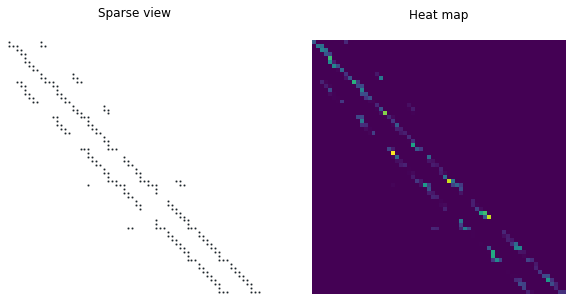

In [20]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x_PDLS, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x_PDLS);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [21]:
if 'γ' not in locals():
    γ = 1

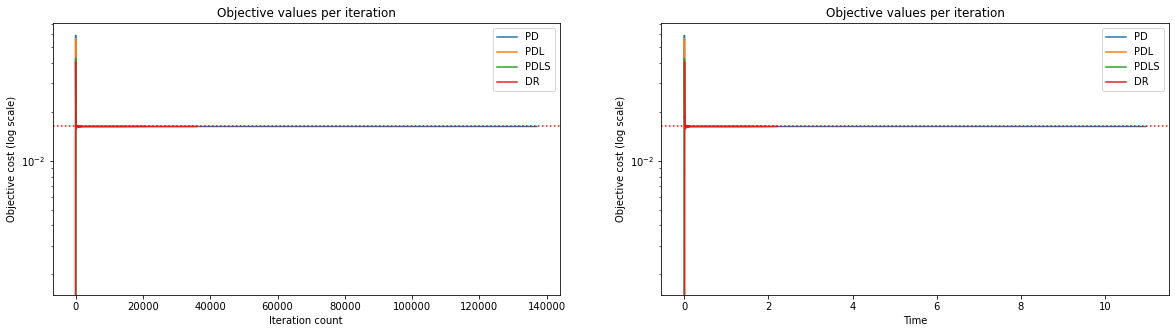

In [22]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj_PD,label='PD')
plt.plot(obj_PDL,label='PDL')
plt.plot(obj_PDLS,label='PDLS')
plt.plot(obj_DR,label='DR')
plt.axhline(y=γ*(obj_exact), color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter_PD['time']),obj_PD,label='PD')
plt.plot(np.append([0], every_iter_PDL['time']),obj_PDL,label='PDL')
plt.plot(np.append([0], every_iter_PDLS['time']),obj_PDLS,label='PDLS')
plt.plot(np.append([0], every_iter_DR['time']),obj_DR,label='DR')
plt.axhline(y=γ*(obj_exact), color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')
plt.legend()
#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

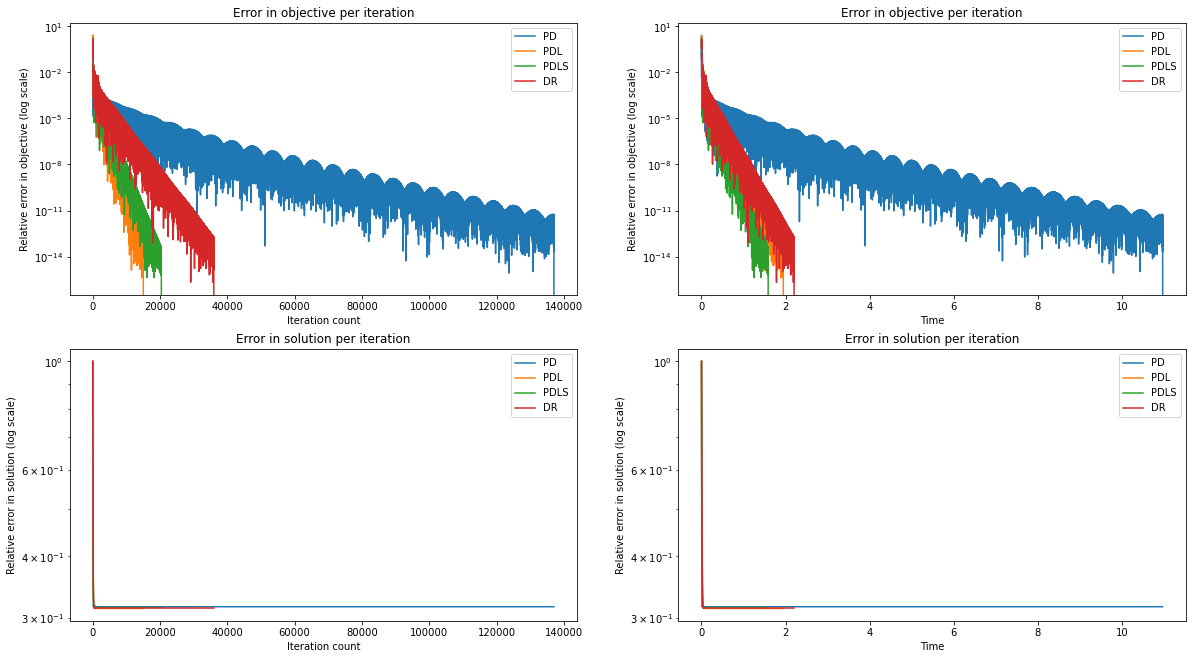

In [23]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter_PD['dist_obj'],label='PD')
plt.plot(every_iter_PDL['dist_obj'],label='PDL')
plt.plot(every_iter_PDLS['dist_obj'],label='PDLS')
plt.plot(every_iter_DR['dist_obj'],label='DR')
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(every_iter_PD['time'],every_iter_PD['dist_obj'],label='PD')
plt.plot(every_iter_PDL['time'],every_iter_PDL['dist_obj'],label='PDL')
plt.plot(every_iter_PDLS['time'],every_iter_PDLS['dist_obj'],label='PDLS')
plt.plot(every_iter_DR['time'],every_iter_DR['dist_obj'],label='DR')
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(every_iter_PD['dist_x'],label='PD')
plt.plot(every_iter_PDL['dist_x'],label='PDL')
plt.plot(every_iter_PDLS['dist_x'],label='PDLS')
plt.plot(every_iter_DR['dist_x'],label='DR')
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(every_iter_PD['time'],every_iter_PD['dist_x'],label='PD')
plt.plot(every_iter_PDL['time'],every_iter_PDL['dist_x'],label='PDL')
plt.plot(every_iter_PDLS['time'],every_iter_PDLS['dist_x'],label='PDLS')
plt.plot(every_iter_DR['time'],every_iter_DR['dist_x'],label='DR')
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')
plt.legend()

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

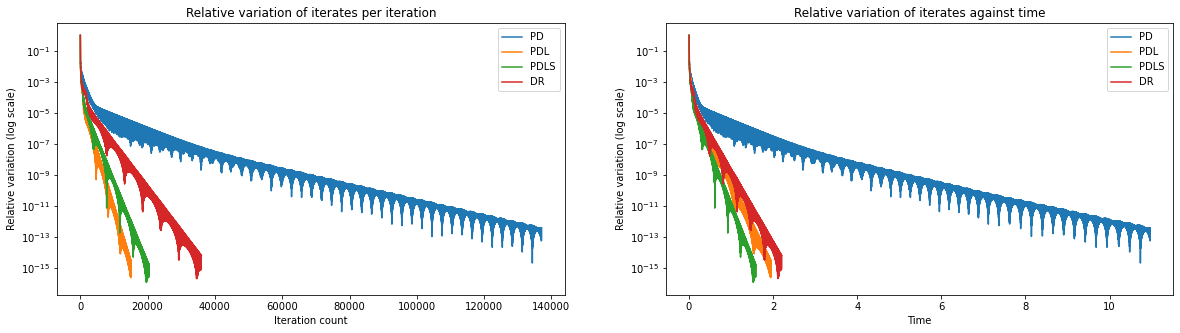

In [24]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter_PD['it'], every_iter_PD['rel_var'],label='PD')
plt.plot(every_iter_PDL['it'], every_iter_PDL['rel_var'],label='PDL')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['rel_var'],label='PDLS')
plt.plot(every_iter_DR['it'], every_iter_DR['rel_var'],label='DR')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter_PD['time'], every_iter_PD['rel_var'],label='PD')
plt.plot(every_iter_PDL['time'], every_iter_PDL['rel_var'],label='PDL')
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['rel_var'],label='PDLS')
plt.plot(every_iter_DR['time'], every_iter_DR['rel_var'],label='DR')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')
plt.legend()

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

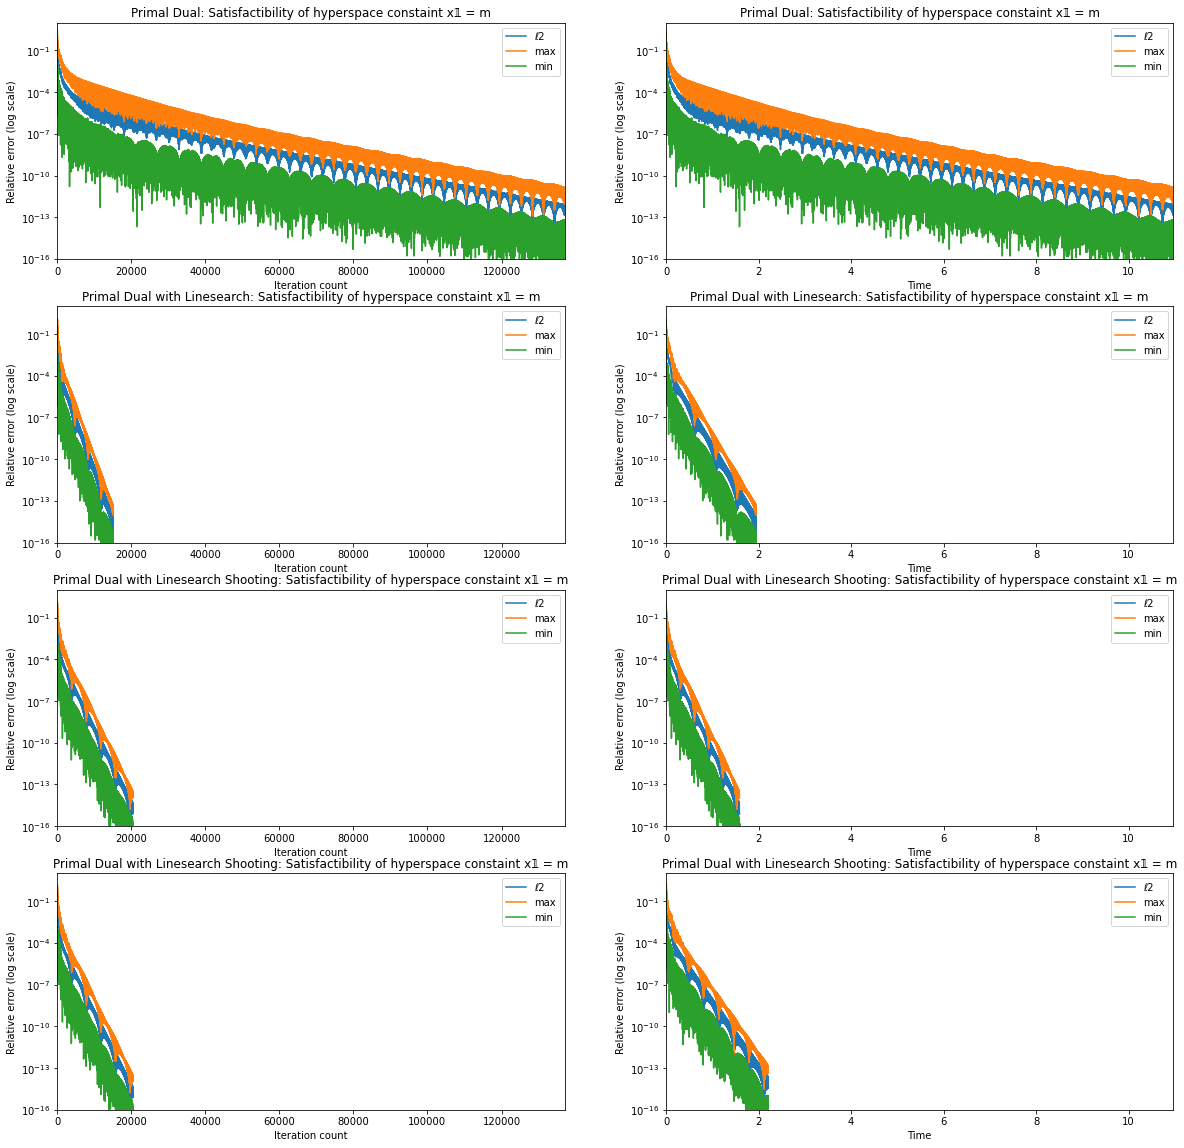

In [25]:
# Relative variation for x𝟙 = m
#put in ylim and xlim
plt.figure(figsize = (20,20))

plt.subplot(4, 2, 1)
plt.xlim([0,len(every_iter_PD['hyperₘ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PD['it'], every_iter_PD['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PD['it'], every_iter_PD['hyperₘ']['max'], label='max')
plt.plot(every_iter_PD['it'], every_iter_PD['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(4, 2, 2)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_PD['time'], every_iter_PD['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PD['time'], every_iter_PD['hyperₘ']['max'], label='max')
plt.plot(every_iter_PD['time'], every_iter_PD['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(4, 2, 3)
plt.xlim([0,len(every_iter_PD['hyperₘ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDL['it'], every_iter_PDL['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PDL['it'], every_iter_PDL['hyperₘ']['max'], label='max')
plt.plot(every_iter_PDL['it'], every_iter_PDL['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual with Linesearch: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(4, 2, 4)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDL['time'], every_iter_PDL['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PDL['time'], every_iter_PDL['hyperₘ']['max'], label='max')
plt.plot(every_iter_PDL['time'], every_iter_PDL['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual with Linesearch: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(4, 2, 5)
plt.xlim([0,len(every_iter_PD['hyperₘ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₘ']['max'], label='max')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual with Linesearch Shooting: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()


plt.subplot(4, 2, 6)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['hyperₘ']['max'], label='max')
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual with Linesearch Shooting: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(4, 2, 7)
plt.xlim([0,len(every_iter_PD['hyperₘ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₘ']['max'], label='max')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual with Linesearch Shooting: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()


plt.subplot(4, 2, 8)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_DR['time'], every_iter_DR['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter_DR['time'], every_iter_DR['hyperₘ']['max'], label='max')
plt.plot(every_iter_DR['time'], every_iter_DR['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual with Linesearch Shooting: Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()


#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

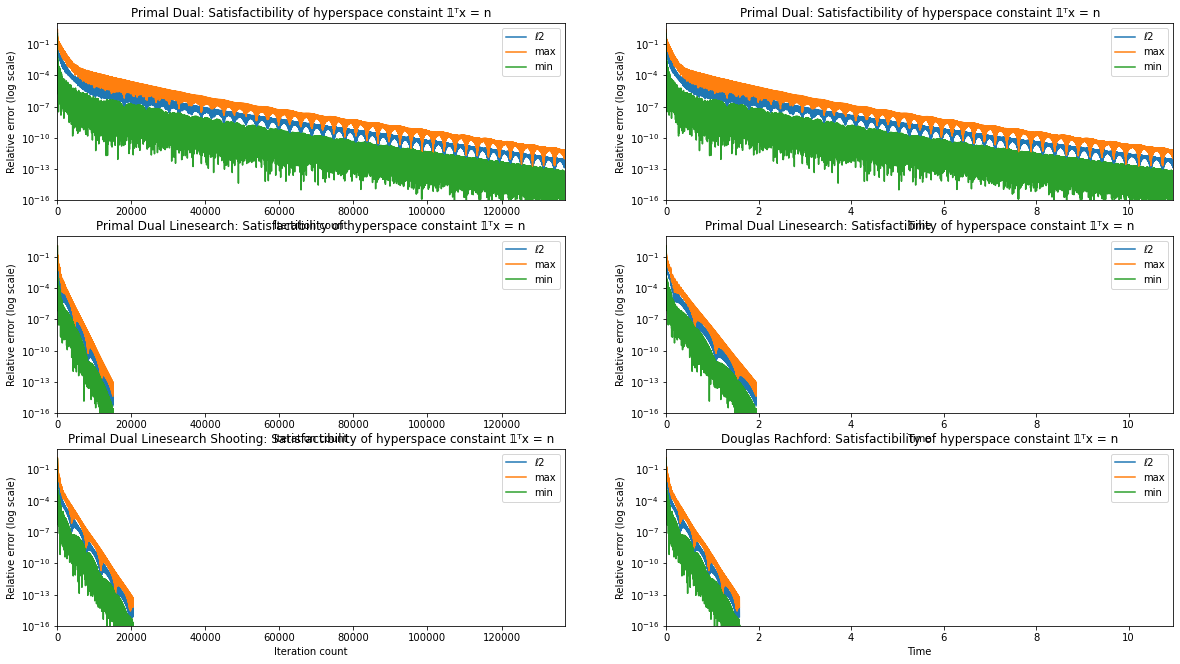

In [26]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,15))

plt.subplot(4, 2, 1)
plt.xlim([0,len(every_iter_PD['hyperₙ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PD['it'], every_iter_PD['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter_PD['it'], every_iter_PD['hyperₙ']['max'], label='max')
plt.plot(every_iter_PD['it'], every_iter_PD['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual: Satisfactibility of hyperspace constaint 𝟙ᵀx = n'); 
plt.legend()

plt.subplot(4, 2, 2)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_PD['time'], every_iter_PD['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter_PD['time'], every_iter_PD['hyperₙ']['max'], label='max')
plt.plot(every_iter_PD['time'], every_iter_PD['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual: Satisfactibility of hyperspace constaint 𝟙ᵀx = n');
plt.legend()

plt.subplot(4, 2, 3)
plt.xlim([0,len(every_iter_PD['hyperₙ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDL['it'], every_iter_PDL['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter_PDL['it'], every_iter_PDL['hyperₙ']['max'], label='max')
plt.plot(every_iter_PDL['it'], every_iter_PDL['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual Linesearch: Satisfactibility of hyperspace constaint 𝟙ᵀx = n'); 
plt.legend()

plt.subplot(4, 2, 4)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDL['time'], every_iter_PDL['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter_PDL['time'], every_iter_PDL['hyperₙ']['max'], label='max')
plt.plot(every_iter_PDL['time'], every_iter_PDL['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual Linesearch: Satisfactibility of hyperspace constaint 𝟙ᵀx = n'); 
plt.legend()

plt.subplot(4, 2, 5)
plt.xlim([0,len(every_iter_PD['hyperₙ']['L2'])])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₙ']['max'], label='max')
plt.plot(every_iter_PDLS['it'], every_iter_PDLS['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Primal Dual Linesearch Shooting: Satisfactibility of hyperspace constaint 𝟙ᵀx = n');  
plt.legend()

plt.subplot(4, 2, 6)
plt.xlim([0,every_iter_PD['time'][-1]])
plt.ylim([1e-16,10])
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['hyperₙ']['max'], label='max')
plt.plot(every_iter_PDLS['time'], every_iter_PDLS['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Douglas Rachford: Satisfactibility of hyperspace constaint 𝟙ᵀx = n'); 
plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

All the data from the above two plots is also available as dataframes:

In [27]:
# df_critical = pd.DataFrame.from_dict(every_critical)
# df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
# df_critical.to_excel(out_folder+'Critical.xlsx')
# display(df_critical)

# # If we want this table in LaTeX format run:
# print(df_critical.to_latex(index=False))

In [28]:
# #df_every = pd.DataFrame.from_dict(every_iter)
# df_every = pd.concat([
#                 pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
#                 pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
#                 pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
# df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
# df_every.to_excel(out_folder+'Every.xlsx')
# display(df_every.head())

In [29]:
# df_every.describe()

In [30]:
# # Finally, store the latest solution:
# np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

Not much of a speedup for interpolation:
```Python
@jit(nopython=True, fastmath = True)
def interp(xₖ,x, yₖ,y, ρ):
    return ρ*xₖ + (1 - ρ)*x, ρ*yₖ + (1 - ρ)*y

xₖ, yₖ, x, y = ones((4,M,N)); ρ = 1.9
interp(xₖ,x, yₖ,y, ρ); # Run it once
```

---